In [1]:
import importlib.util

package_name = 'trimesh'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install trimesh
else:
    print(package_name +" is installed")
    
package_name = 'mahotas'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install mahotas
else:
    print(package_name +" is installed")

import numpy as np
import math
import cv2
import os
import pandas as pd
import mahotas
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import regionprops
from skimage.transform import rescale, resize
from skimage.morphology import thin
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from matplotlib.ticker import MultipleLocator
from utils import dataset_loader, my_utils, Operations, Moments, generate_point_cloud
import warnings
warnings.filterwarnings('ignore')

from plyfile import PlyData, PlyElement

%matplotlib inline

trimesh is installed
mahotas is installed


In [2]:
def calc_mue(M):
    """
     Args:
         M: point cloud
    returns mean of a point cloud
    """
    return np.mean(M, axis=0)

def calc_dist(p, mue): 
    """    
    At first, minus mue from point clouds, then calculate square 2 of them
     Args:
         p:   point cloud
         mue: mean of point cloud
    
    returns: calculated distance
    """
    return np.linalg.norm(p-mue, 2)

In [3]:
# # dataset_dict = DATA
# surfs=['Real Data','Drop 35C','Lower and Higher']
# surf = surfs[0]
# print(surf)
# sample_per_class = 1
# colors = ['g', 'b', 'k', 'y', 'm', 'c']
# i = -1
# cmf = []
# all_cmf = []
# points = DATA
# mue = calc_mue(points)
# # print("mue: ", mue)
# sorted_dists = sorted([calc_dist(p, mue) for p in points])
# print("\n sorted_dists: ", len(sorted_dists))
# XY = [(0, 0)]
# t = len(sorted_dists)
# for j, d in enumerate(sorted_dists):
#     XY.append((d,1.*j/t))
# x, y = [xy[0] for xy in XY], [xy[1] for xy in XY]
# cmf.append(y)

# fig = plt.figure(figsize=(25,5))
# ax1 = fig.add_subplot(1, 1, 1)
# ax1.plot(x, y, colors[0] ,label='CMF')
# ax1.set_xlabel('Distance')
# ax1.set_ylabel('Probablity')
# ax1.set_title('CMF '+'of {}'.format(surf))
# ax1.legend()

# plt.show()
# all_cmf.append(cmf)
# # print(all_cmf)
# # def depict_cmf(dataset_dict, sample_per_class = 4, colors = ['g', 'b', 'k', 'y', 'm', 'c']):
# #     """
# #     This function receives a list of point clouds for a class(PEG,ODS,FOCTS,GLAS) and draws 
# #     cumulative distribution function (CDF) all point clouds.
# #     In each row draws 4 point clouds. 
# #     colors contain 6  diffrent colors. 
    
    
# #      Args:
# #          PC_list: a list of point clouds
# #          colors: list of 6 colors for depicting each row    
# #          class_label: class label
# #     """
# #     i = -1
# #     all_cmf = []
# #     for surf in surface:
# #         fig = plt.figure(figsize=(25,5))
# #         i = i+1
# #         pcs = dataset_dict[surf]
# #         sample_per_class = sample_per_class if (len(pcs)>sample_per_class) else len(pcs)
#         cmf = []
#         for idx in range(sample_per_class):
#             points = pcs[idx]
#             ax1 = fig.add_subplot(1, 4, idx+1)
#             mue = calc_mue(points)
#             sorted_dists = sorted([calc_dist(p, mue) for p in points])
#             XY = [(0, 0)]
#             t = len(sorted_dists)
#             for j, d in enumerate(sorted_dists):
#                 XY.append((d,1.*j/t))
#             x, y = [xy[0] for xy in XY], [xy[1] for xy in XY]
#             cmf.append(y)
#             ax1.plot(x, y, colors[i] ,label='CMF')
#             ax1.set_xlabel('Distance')
#             ax1.set_ylabel('Probablity')
#             ax1.set_title('CMF '+dataset_dict['selected_polymer']+' class:{}, #:{} '.format(surf, idx))
#             ax1.legend()
#         plt.show()
#         all_cmf.append(cmf)
#     return all_cmf

# Depict figs with 3 curves (real/drop/hi-lo)

In [50]:

def norm_points(DATA, do_normalize):
    processed_points = []      
    points  = DATA
    confidence = 0.99

    if do_normalize:
        Inlaier_points = []
        mue            = calc_mue(points)# cal mean of a point cloud
    #     print(mue.shape)
    #     print('mue', mue)
        sorted_dists   = sorted([calc_dist(p, mue) for p in points])
        XY             = [(0, 0)]
        t              = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append(( d, 1.*j/t ))
            if 1.*j/t >= confidence:
                break
        sorted_idx     = sorted([(i, my_utils.calc_dist(p, mue)) for i, p in enumerate(points)], key= lambda d:(d[1], d[0]))
        inlaier        = [d[0] for d in sorted_idx[:j]]
        inlaier_points = [points[j] for j in inlaier]
        points         = np.array(inlaier_points)
    #     print(points.shape)
        points        -= mue
    
    return points


def depict_cmf_group(dataset_dict, surfaces, temperature, sample_index, sample_per_class = 3, colors = ['g', 'b', 'k', 'y', 'm', 'c']):
    """
    This function receives a list of point clouds for a class(PEG,ODS,FOCTS,GLAS) and draws 
    cumulative distribution function (CDF) all point clouds.
    In each row draws 4 point clouds. 
    colors contain 6  diffrent colors. 
    
    
     Args:
         PC_list: a list of point clouds
         colors: list of 6 colors for depicting each row    
         class_label: class label
    """
    i = 0
    group_cmf = []
    fig = plt.figure(figsize=(10,10))
    for surf in surfaces:
        points = dataset_dict[i]
        ax1 = fig.add_subplot(1, 1, 1)
        mue = calc_mue(points)
        sorted_dists = sorted([calc_dist(p, mue) for p in points])
        XY = [(0, 0)]
        t = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append((d,1.*j/t))
        x, y = [xy[0] for xy in XY], [xy[1] for xy in XY]
        x = x/np.max(x)
        group_cmf.append(y)
        ax1.plot(x, y, colors[i], label="CMF "+surf)
        i += 1

    plt.legend(loc="upper right")
    ax1.set_xlabel('Distance')
    ax1.set_ylabel('Probablity')
#     ax1.set_title('CMF: {}C-Sample #{}'.format(temperature, sample_index))
    plt.show()
    fig.savefig('/home/students/yiwei/Documents/dataset/CMF-Sample-FOCTS-ODS-PEG'+'.pdf', bbox_inches='tight')
    return group_cmf

In [55]:
dataset_dict = {}
# surfaces = ['Real_Data','Drop_35C','Lower_and_Higher']
surfaces = ['FOCTS','ODS','PEG']
# tmp_index = 6;#[1,6]

# if tmp_index == 1:
#     temperature = '21'
# elif tmp_index == 2:
#     temperature = '33'
# elif tmp_index == 3:
#     temperature = '35'
# elif tmp_index == 4:
#     temperature = '38'
# elif tmp_index == 5:
#     temperature = '43'
# else:
#     temperature = '53'
    
temperature = 24
do_normalize = True
# for index in range(4):
for index in range(1):
#     sample_index = index+1  
#     ply_type = ['_go', 'gg', 'gg']
    for inx, surf in enumerate(surfaces): 

        DATA_DIR = "/home/students/yiwei/Documents/dataset"
        if inx == 0:
            sample_inx = 3
        elif inx == 1:
            sample_inx = 9
        else:
            sample_inx = 1
        
        print(f"inx: {sample_inx}")
        file = os.path.join(DATA_DIR,surf+'-loc-'+str(sample_inx)+'.txt')
#         info_file = os.path.join(DATA_DIR,"sample_"+str(sample_index)+"info"+str(tmp_index)+'.3d')
        print(file)
#         print(info_file)
        DATA = np.loadtxt(file, delimiter=",")
#         DATA = pd.read_csv(file, delimiter = "\t", header=None)
#         INFO = pd.read_csv(info_file, delimiter = "\t", header=None)
#         print(DATA)
        DATA = DATA.astype(np.float)
        DATA = norm_points(DATA, do_normalize)
#         INFO = INFO.to_numpy()
#         print(DATA)
        # print(INFO)
#         DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
#         DATA = DATA[:,:3]#only extract the location information

        dataset_dict[surf] = DATA
    #     print(dataset_dict)

    dataset_list = []
    dataset_list.append(dataset_dict[surfaces[0]])
    dataset_list.append(dataset_dict[surfaces[1]])
    dataset_list.append(dataset_dict[surfaces[2]])

    

inx: 3
/home/students/yiwei/Documents/dataset/FOCTS-loc-3.txt
inx: 9
/home/students/yiwei/Documents/dataset/ODS-loc-9.txt
inx: 1
/home/students/yiwei/Documents/dataset/PEG-loc-1.txt


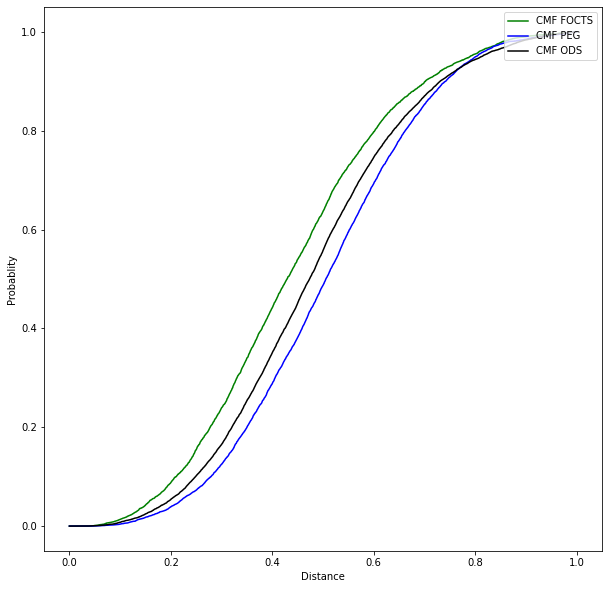

In [57]:
group_cmf = []
surfaces=['FOCTS','PEG','ODS']
group_cmf = depict_cmf_group(dataset_list, surfaces,temperature,sample_index=1, sample_per_class = 3)


# Depict figs with samples per class 

In [53]:
def depict_cmf_samples(dataset_dict, surfaces, type_inx, sample_per_class = 6, colors = ['g', 'b', 'k', 'y', 'm', 'c']):
    """
    This function receives a list of point clouds for a class(PEG,ODS,FOCTS,GLAS) and draws 
    cumulative distribution function (CDF) all point clouds.
    In each row draws 4 point clouds. 
    colors contain 6  diffrent colors. 
    
    
     Args:
         PC_list: a list of point clouds
         colors: list of 6 colors for depicting each row    
         class_label: class label
    """
    i = 0
    group_cmf = []
    experiments = ['real_data','Drop_35','Hi_lo']
    experiment = experiments[type_inx]
    fig = plt.figure(figsize=(7,7))
    for surf in surfaces:

#         points = np.concatenate(dataset_dict[i], axis= 0)
        points = dataset_dict[i]
        ax1 = fig.add_subplot(1, 1, 1)
        mue = calc_mue(points)
        sorted_dists = sorted([calc_dist(p, mue) for p in points])
        XY = [(0, 0)]
        t = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append((d,1.*j/t))
        x, y = [xy[0] for xy in XY], [xy[1] for xy in XY]
        x = x/np.max(x)
        group_cmf.append(y)
        ax1.plot(x, y, colors[i], label="CMF "+surf)
        i += 1

    plt.legend(loc="upper right")
    ax1.set_xlabel('Distance')
    ax1.set_ylabel('Probablity')
    ax1.set_title('CMF: {} of all temperatures'.format(experiment))
    plt.show()
    
    fig.savefig('CMF_best_'+experiment+'.pdf', bbox_inches='tight')
    return group_cmf

## Concatenate all the samples



21


/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_1_go1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_1info1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_2_go1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_2info1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_3_go1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_3info1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_4_go1.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_4info1.3d


33


/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_1_go2.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_1info2.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_2_go2.3d
/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp/sample_2info2.3d
/home/students/yiwei/Documents/r

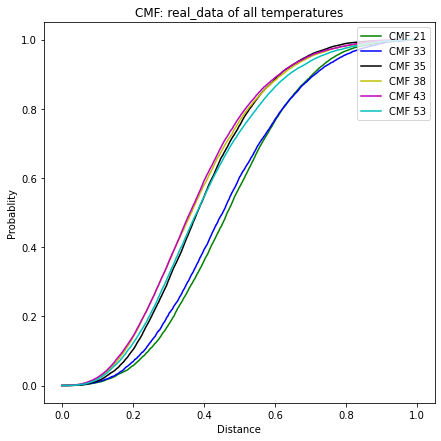

In [46]:
type_inx = 0#declare the experiment 
#0:real 1:drop 2:hi-lo

dataset_dict = {}
surfaces = ['21','33','35','38','43','53']

ply_type = ['_go', 'gg', 'gg']#0:real 1:drop 2:hi-lo

if type_inx == 0:
    DATA_DIR    =  "/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp"
elif type_inx == 1:
    DATA_DIR    = "/home/students/yiwei/Documents/result_drop35/results/results_mtemp"
else:
    DATA_DIR    = "/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp"
    
    

#dataset_dict=['21C':4 samples; '33': 4 samples, '35': 4 samples....]

for inx, surf in enumerate(surfaces): 
    tmp_index = inx+1
    temperature = surf
    print('\n\n{}\n\n'.format(temperature))
    TEMP = []
    for index in range(4):
        sample_index = index + 1
        file = os.path.join(DATA_DIR,"sample_"+str(sample_index)+ply_type[type_inx]+str(tmp_index)+'.3d')
        info_file = os.path.join(DATA_DIR,"sample_"+str(sample_index)+"info"+str(tmp_index)+'.3d')
        print(file)
        print(info_file)
        DATA = pd.read_csv(file, delimiter = "\t", header=None)
        INFO = pd.read_csv(info_file, delimiter = "\t", header=None)
        DATA = DATA.to_numpy()
        INFO = INFO.to_numpy()
        DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
        DATA = DATA[:,:3]#only extract the location information
        do_normalize = True
        norm_data = norm_points(DATA,do_normalize)
#         print('\n\n norm_data {}\n\n'.format(norm_data))
        TEMP.append(norm_data)
#         print('\nTEMP Len:{}\n'.format(len(TEMP)))

    dataset_dict[surf] = TEMP
#     print('\n\n dataset_dict len: {}\n\n'.format(len(dataset_dict)))

dataset_list = []
for id in range(len(dataset_dict)):
    dataset_list.append(dataset_dict[surfaces[id]])
 


group_cmf = depict_cmf_samples(dataset_list, surfaces,type_inx, sample_per_class = 6)

## Only check the best one



21


/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_4gg1.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_4info1.3d


 dataset_dict len: 1




33


/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2gg2.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2info2.3d


 dataset_dict len: 2




35


/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_1gg3.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_1info3.3d


 dataset_dict len: 3




38


/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2gg4.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2info4.3d


 dataset_dict len: 4




43


/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_4gg5.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_4info5.3d


 dataset_dict len: 5




53


/ho

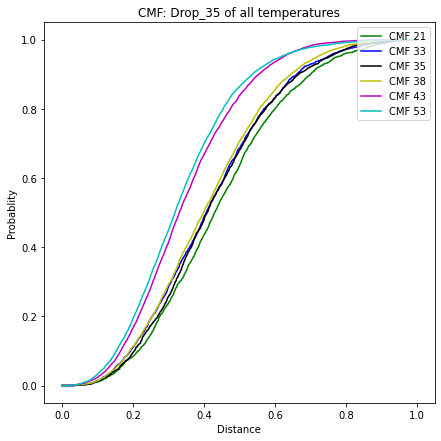

In [62]:
type_inx = 1#declare the experiment 
#0:real 1:drop 2:hi-lo

dataset_dict = {}
surfaces = ['21','33','35','38','43','53']

ply_type = ['_go', 'gg', 'gg']#0:real 1:drop 2:hi-lo

if type_inx == 0:
    DATA_DIR    =  "/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp"
elif type_inx == 1:
    DATA_DIR    = "/home/students/yiwei/Documents/result_drop35/results/results_mtemp"
else:
    DATA_DIR    = "/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp"
    
# #Best single sample
# real=[]
# Drop35=[any,any ,2/3,2/4,2/4太过了 1/3很像，1]
# Hi_lo=[any,any,3/1,4/3,1/3,4]
# 21 33 35 38 43 53
best_go = [2,2,2,1,3,3] 
best_drop35 = [4,2,1,2,4,1]
best_hi_lo = [2,2,3,3,4,4]

#dataset_dict=['21C':4 samples; '33': 4 samples, '35': 4 samples....]

for inx, surf in enumerate(surfaces): 
    tmp_index = inx+1
    temperature = surf
    print('\n\n{}\n\n'.format(temperature))
    
    if type_inx == 0:
        best_sample = best_go
    elif type_inx == 1:
        best_sample = best_drop35
    else:
        best_sample = best_hi_lo
            
    sample_index = index + 1
    file = os.path.join(DATA_DIR,"sample_"+str(best_sample[inx])+ply_type[type_inx]+str(tmp_index)+'.3d')
    info_file = os.path.join(DATA_DIR,"sample_"+str(best_sample[inx])+"info"+str(tmp_index)+'.3d')
    print(file)
    print(info_file)
    DATA = pd.read_csv(file, delimiter = "\t", header=None)
    INFO = pd.read_csv(info_file, delimiter = "\t", header=None)
    DATA = DATA.to_numpy()
    INFO = INFO.to_numpy()
    DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
    DATA = DATA[:,:3]#only extract the location information
    do_normalize = True
    norm_data = norm_points(DATA,do_normalize)
#         print('\n\n norm_data {}\n\n'.format(norm_data))
        

    dataset_dict[surf] = DATA
    print('\n\n dataset_dict len: {}\n\n'.format(len(dataset_dict)))

dataset_list = []
for id in range(len(dataset_dict)):
    dataset_list.append(dataset_dict[surfaces[id]])

# print('\n\n dataset_list len: {}\n\n'.format(len(dataset_list)))
# print(dataset_list)

group_cmf = depict_cmf_samples(dataset_list, surfaces,type_inx, sample_per_class = 6)

# Normalized aggregation CMF

In [48]:
# def depict_cmf_aggregation(dataset_dict, surfaces, temperature, sample_per_class = 3, colors = ['g', 'b', 'k', 'y', 'm', 'c']):
#     """
#     This function receives a list of point clouds for a class(PEG,ODS,FOCTS,GLAS) and draws 
#     cumulative distribution function (CDF) all point clouds.
#     In each row draws 4 point clouds. 
#     colors contain 6  diffrent colors. 
    
    
#      Args:
#          PC_list: a list of point clouds
#          colors: list of 6 colors for depicting each row    
#          class_label: class label
#     """
#     i = 0
#     group_cmf = []
#     fig = plt.figure(figsize=(10,10))
#     for surf in surfaces:
#         points = dataset_dict[i]
#         ax1 = fig.add_subplot(1, 1, 1)
#         mue = calc_mue(points)
#         sorted_dists = sorted([calc_dist(p, mue) for p in points])
#         XY = [(0, 0)]
#         t = len(sorted_dists)
#         for j, d in enumerate(sorted_dists):
#             XY.append((d,1.*j/t))
#         x, y = [xy[0] for xy in XY], [xy[1] for xy in XY]
#         x = x/np.max(x)
#         group_cmf.append(y)
#         ax1.plot(x, y, colors[i], label="CMF "+surf)
#         i += 1

#     plt.legend(loc="upper right")
#     ax1.set_xlabel('Distance')
#     ax1.set_ylabel('Probablity')
#     ax1.set_title('CMF: {}C '.format(temperature))
#     plt.show()
#     fig.savefig('CMF_'+temperature+'C'+'.pdf', bbox_inches='tight')
#     return group_cmf

/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_1_go6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_1info6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2_go6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2info6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_3_go6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_3info6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_4_go6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_4info6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_1gg6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_1info6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2gg6.3d
/home/students/yiwei/Documents/result_drop35/results/results_mtemp/sample_2info6.3d


ValueError: Improper number of dimensions to norm.

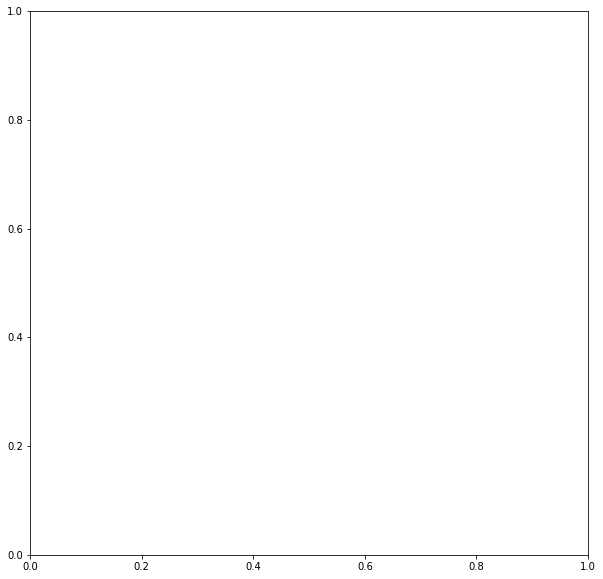

In [49]:
# dataset_dict = {}
# surfaces = ['Real_Data','Drop_35C','Lower_and_Higher']

# tmp_index = 6;#[1,6]

# if tmp_index == 1:
#     temperature = '21'
# elif tmp_index == 2:
#     temperature = '33'
# elif tmp_index == 3:
#     temperature = '35'
# elif tmp_index == 4:
#     temperature = '38'
# elif tmp_index == 5:
#     temperature = '43'
# else:
#     temperature = '53'
    
  

    
# ply_type = ['_go', 'gg', 'gg']
# for inx, surf in enumerate(surfaces): 
#     # Real data
#     if inx == 0:
#         DATA_DIR    =  "/home/students/yiwei/Documents/result_drop35/results/results_mtemp"
#     elif inx == 1:
#         DATA_DIR    = "/home/students/yiwei/Documents/result_drop35/results/results_mtemp"
#     else:
#         DATA_DIR    = "/home/students/yiwei/Documents/rez_hi_lo/results/results_mtemp"

#     TEMP=[] 
#     for index in range(4):
#         sample_index = index+1  

#         file = os.path.join(DATA_DIR,"sample_"+str(sample_index)+ply_type[inx]+str(tmp_index)+'.3d')
#         info_file = os.path.join(DATA_DIR,"sample_"+str(sample_index)+"info"+str(tmp_index)+'.3d')
#         print(file)
#         print(info_file)
#         DATA = pd.read_csv(file, delimiter = "\t", header=None)
#         INFO = pd.read_csv(info_file, delimiter = "\t", header=None)
#         DATA = DATA.to_numpy()
#         INFO = INFO.to_numpy()

#         DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
#         DATA = DATA[:,:3]#only extract the location information
#         TEMP.append(DATA)

#     dataset_dict[surf] = DATA
# #     print(dataset_dict)

# dataset_list = []
# dataset_list.append(np.concatenate(dataset_dict[surfaces[0]], axis= 0))
# dataset_list.append(np.concatenate(dataset_dict[surfaces[1]], axis= 0))
# dataset_list.append(np.concatenate(dataset_dict[surfaces[2]], axis= 0))

# group_cmf = []
# group_cmf = depict_cmf_aggregation(dataset_list, surfaces,temperature, sample_per_class = 3)